# Analysis and Visualization

In this notebook we perform some analysis and visualization of the historical Bixi trip data.

**TBA**:
* Visualizations on the overall bixi usage in addition to just Metro Mont-Royal.
* Plots of trip count by weekday, overall correlation of weekend/holidays with Bixi usage.
* Visualizations or dock station demand.
* Correlation of certain weather variables with Bixi usage. Does the weather help explain some of the "noise" we're seeing?


Required imports:

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels for time-series decomposition and autocorrelation
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

### Load the Data

Load the Mon-Royal trip history data.

In [93]:
mr_bike_demand = pd.read_csv('data/mr_bike_demand.csv', index_col='start_date', parse_dates=['start_date'])
display(mr_bike_demand.head())

,trip_count
start_date,
2014-04-15,31
2014-04-16,67
2014-04-17,140
2014-04-18,108
2014-04-19,128


## Demand history plots

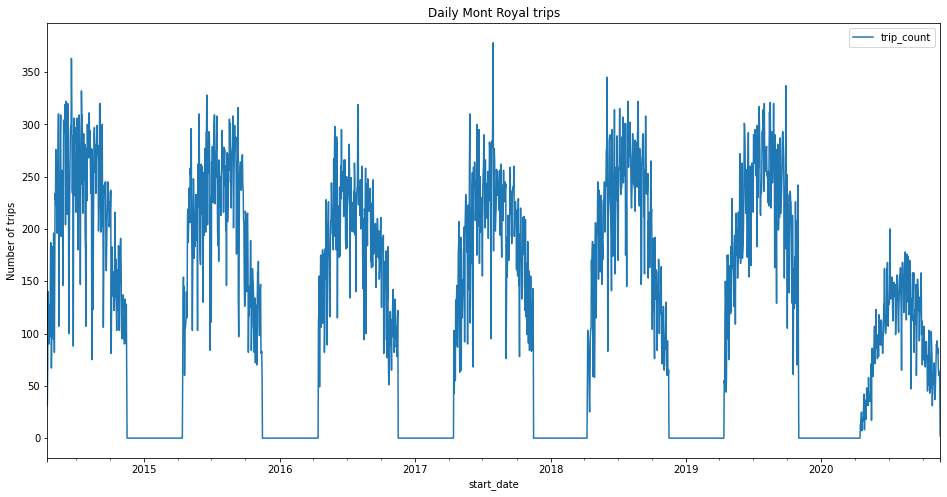

In [94]:
# Daily plot
mr_bike_demand.plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Daily Mont Royal trips')
plt.show()

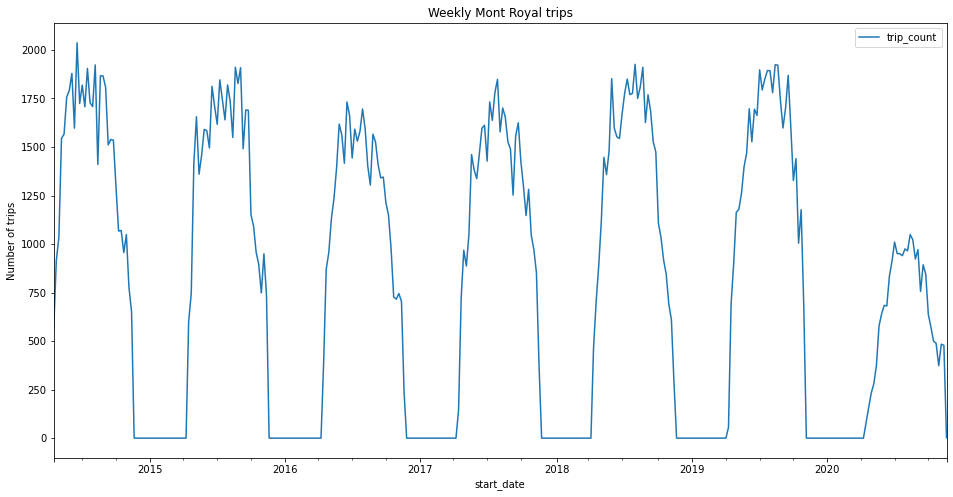

In [95]:
# Weekly plot
mr_bike_demand.resample('W').sum().plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Weekly Mont Royal trips')
plt.show()

As we can see, there is a very clear yearly periodicity on the data.

Let's zoom in on a particular year/month and examine shorter terms history.

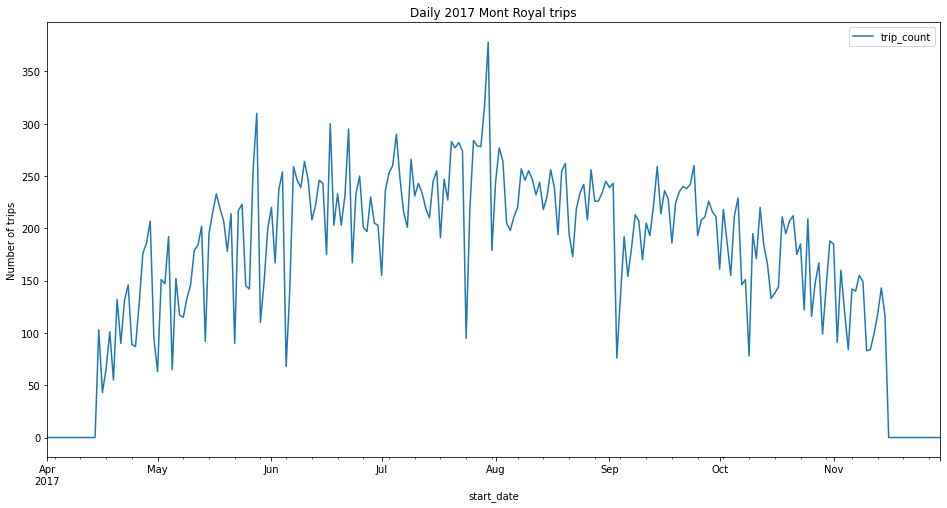

In [97]:
# Daily plot for 2017
mr_bike_demand.loc['2017-04':'2017-11'].plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Daily 2017 Mont Royal trips')
plt.show()

There is a clear pattern within this year, with the demand steadily increasing until the peak in late July/early August and then decreasing.

Let's look at the data for one month and the weekday data.

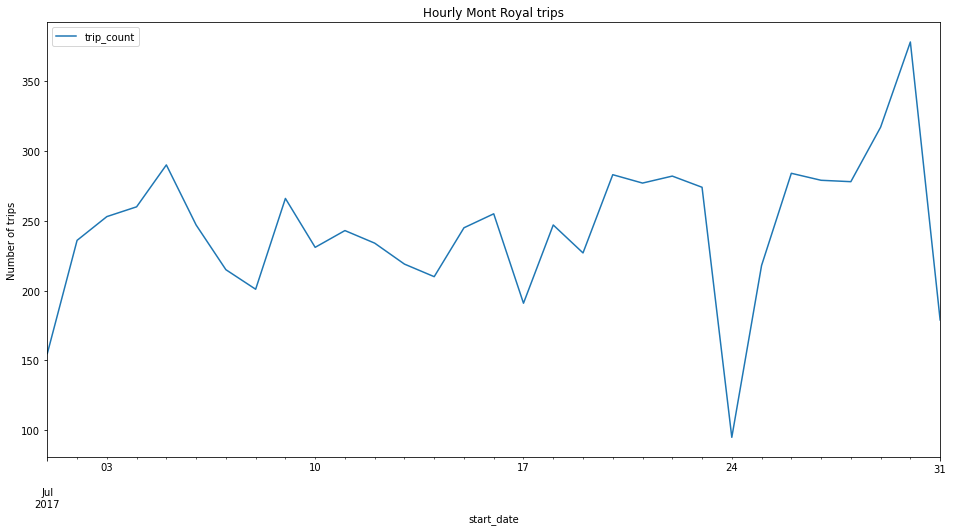

In [98]:
# Daily plot for July 2017
mr_bike_demand.loc['2017-07'].plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Hourly Mont Royal trips')
plt.show()

In [101]:
# Copy July demand into a new data frame
july_demand = mr_bike_demand.loc['2017-07'].copy()

# Add weekdays to each sample
july_demand['weekday'] = july_demand.index.day_name()

weekday
Friday       AxesSubplot(0.125,0.125;0.775x0.755)
Monday       AxesSubplot(0.125,0.125;0.775x0.755)
Saturday     AxesSubplot(0.125,0.125;0.775x0.755)
Sunday       AxesSubplot(0.125,0.125;0.775x0.755)
Thursday     AxesSubplot(0.125,0.125;0.775x0.755)
Tuesday      AxesSubplot(0.125,0.125;0.775x0.755)
Wednesday    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

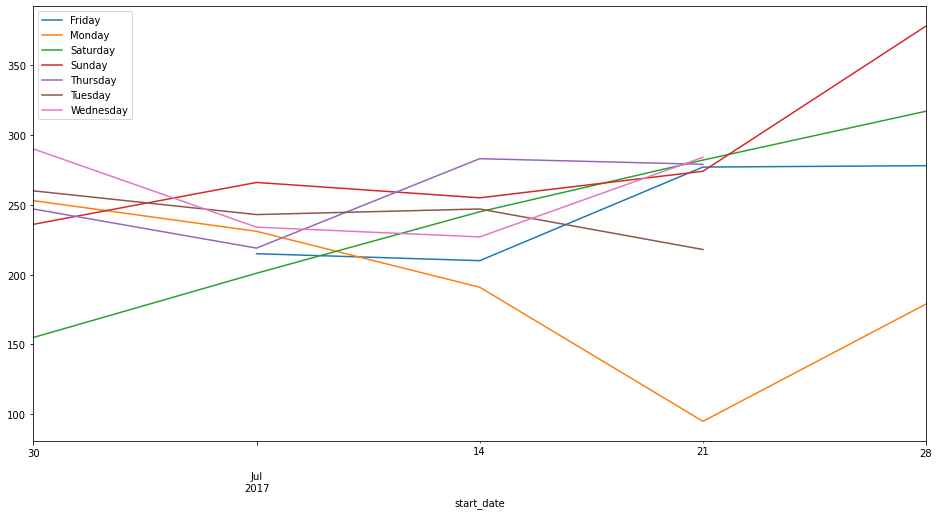

In [102]:
# Group by weekday and plot
fig, ax = plt.subplots(figsize=(16, 8))
july_demand.groupby('weekday').apply(lambda x: x['trip_count'].plot(x=x.index, ax=ax, legend=True, label=x['weekday'][0]))

**Note**: for some reason the a-axis actually evently spaces all points and does not use timestamps - need to find a way to arrange the plots properly.

## Seasonal Decomposition

Decompose the data into trend, periodic and noise components.

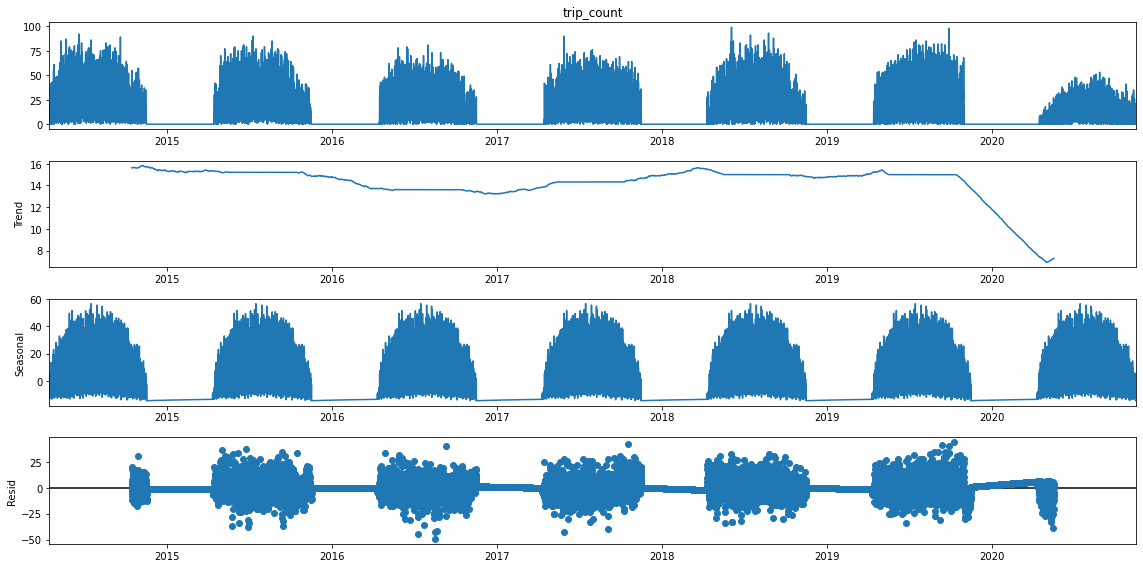

In [103]:
# Configure the period to be annual
samples_per_day = 8
days_per_year = 365
period = samples_per_day * days_per_year

plt.rc("figure", figsize=(16,8))
decomposed_trip_data = sm.tsa.seasonal_decompose(station_demand["trip_count"], period=period)
figure = decomposed_trip_data.plot()
plt.show()

A few observations:
* The trend is relatively constant throughout the years with a large dip at the end of 2019 (missing November data) and into 2020 (pandemic)
* There a strong overall yearly periodic component
* There is still a significant amount of noise among individual samples

## Autocorrelation

Let's see what the autocorrelation looks like with up to 1 year lag.

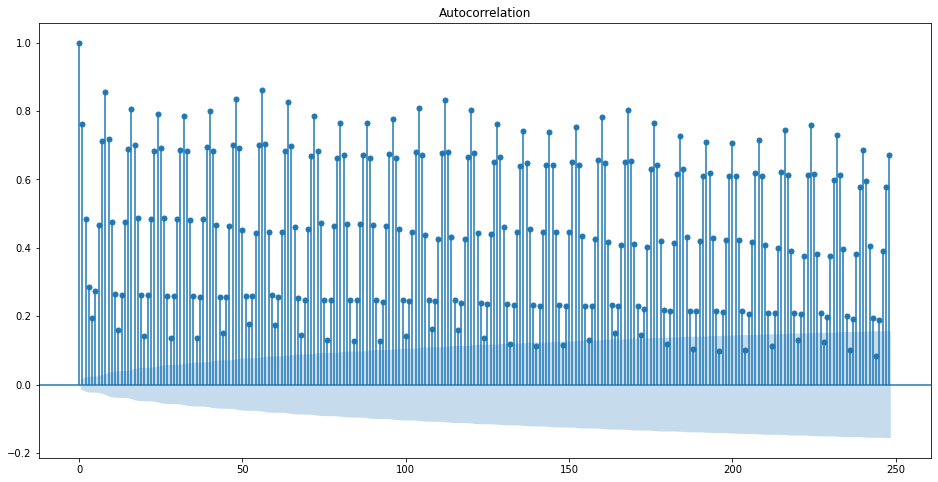

In [104]:
# Autocorrelation with up to month lag
plt.rc("figure", figsize=(16,8))
plot_acf(station_demand["trip_count"], lags=248)
plt.show()

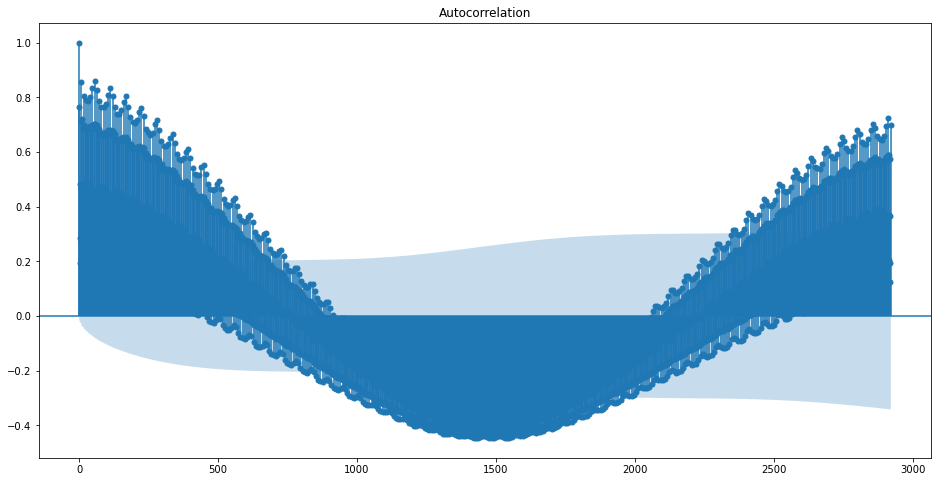

In [105]:
# Autocorrelation with up to year lag
plt.rc("figure", figsize=(16,8))
plot_acf(station_demand["trip_count"], lags=period)
plt.show()

As we can see, there is a statistically significant autocorrelation at each level:
* Previous day/week/month usage is generally correlated with the next
* Previous year usage is generally correlated with the next